In [111]:
#Experiment 1: varying sample size adding additive noise with std = 0.2

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

n = range(5,201, 10)
n_2 = range(0,100,1)
f = 2 # the frequency for sin signal


test_error = np.zeros([3,len(n)])
train_error = np.zeros([3,len(n)])
temp_test = np.zeros([3,len(n_2)])
temp_train = np.zeros([3,len(n_2)])
temp_L = np.zeros([3,len(n_2)])
Rad = np.zeros([3,len(n)])


for counter,value in enumerate(n): 
    for j in n_2:
        #step 1 - data generation
        fs = value #sample rate for sin signal
        X = np.vstack([[np.random.uniform(0,1,value).reshape(-1,1)],         
                       [np.random.uniform(0,1,value).reshape(-1,1)],
                       [np.arange(fs).reshape(-1,1)]])
        e = np.random.normal(0,0.2,value).reshape(-1,1)
        #Y in order linear, quadratic and sin
        Y = np.vstack([[(10.5*X[0] +5 + e).reshape(-1,1)],
                      [(10.5*X[1] + 90*X[1]**2 +5 + e).reshape(-1,1)],
                       [np.sin(2*np.pi*f*(X[2]/fs)).reshape(-1,1)]])
    
        #shuffling sin
        idx = np.random.permutation(Y[2].shape[0])
        X[2]= X[2,idx]
        Y[2]= Y[2,idx]    
        
        #train split 
        X_train, X_test = np.hsplit(X, [int(.8*int(X.shape[1]))])
        Y_train, Y_test = np.hsplit(Y, [int(.8*int(Y.shape[1]))])
        Y_pred_train = np.empty_like(Y_train)
        Y_pred_test = np.empty_like(Y_test)
        
        #rademacher sigma
        s = np.random.binomial(1,0.5, int(Y_train[0].shape[0]))
        a = sum(s)
        while a.all() !=0:
            s = np.random.binomial(1,0.5, int(Y_train[0].shape[0]))
            s[s < 1] = -1
            a = sum(s)
        
        for i in range(0,3,1):
            
            #Step 2: model fitting
            #initialisation of linear regression/insert data for training/prediction
            m = LinearRegression()

            #inserting train data in model for training
            m.fit(X_train[i],Y_train[i])

            #predicting values for test data
            Y_pred_test[i] = m.predict(X_test[i])
            Y_pred_train[i] = m.predict(X_train[i])

            #computing RMSE
            error_test= np.sqrt(mean_squared_error(Y_test[i], Y_pred_test[i]))
            temp_test[i,j] =  error_test

            error_train= np.sqrt(mean_squared_error(Y_train[i], Y_pred_train[i]))
            temp_train[i,j] = error_train
            
            #Rademacher constant
            L = np.dot(s, np.sqrt((Y_train[i]-Y_pred_train[i])**2))/len(Y_train[i])
            temp_L[i,j] = L

    test_error[:,counter] = np.mean(temp_test, axis = 1)
    train_error[:,counter] = np.mean(temp_train, axis = 1)
    Rad[:,counter] = np.amax(temp_L, axis = 1)    

In [112]:
#Calculating Rademacher bound for regression
bound = np.zeros([3,len(n)])
delta = 0.1
c1 = 0.3*(np.sqrt(np.log(2/delta)/(2*np.array(n))))
for i in range(0,3):
    bound[i] = np.add(train_error[i], Rad[i])
    bound[i] = np.add(bound[i],c1)
print(bound)

[[0.36299915 0.35971652 0.32735295 0.32853376 0.28519521 0.28371516
  0.27494887 0.29571144 0.26570022 0.27031657 0.26100511 0.26832726
  0.2651688  0.25079753 0.2500683  0.24723944 0.25124725 0.25212795
  0.24673303 0.26163477]
 [7.01676366 7.65405597 7.92567939 7.7416814  8.19910631 8.07496509
  7.51012204 7.70441249 7.80453137 7.44755902 7.66670269 7.41212852
  7.72655947 7.40344732 7.44789895 7.75655909 7.31516973 7.28388241
  7.3251422  7.70092624]
 [1.14948486 0.97680206 0.90233779 0.89650972 0.8273165  0.84250644
  0.8154268  0.81002866 0.78839877 0.76487273 0.7779133  0.78161263
  0.75635176 0.7580028  0.76927658 0.75982029 0.7471175  0.74830634
  0.77376303 0.74267331]]


In [113]:
#VC dimension
VC = np.zeros([3,len(n)])
c2 = np.array(n)/(2*np.log(n))
for i in range(0,3):
    VC[i] = (Rad[i]**2)*c2
    
boundVC = np.zeros([3,len(n)])
delta = 0.1
a = VC[i]/np.array(n)
c3 = np.log(np.array(n))/2*(np.array(n))
for i in range(0,3):
    boundVC[i] = train_error[i]/(1- np.sqrt(a[i]-(a[i]*np.log(a[i]))+c3[i]))
print(bound)

[[0.36299915 0.35971652 0.32735295 0.32853376 0.28519521 0.28371516
  0.27494887 0.29571144 0.26570022 0.27031657 0.26100511 0.26832726
  0.2651688  0.25079753 0.2500683  0.24723944 0.25124725 0.25212795
  0.24673303 0.26163477]
 [7.01676366 7.65405597 7.92567939 7.7416814  8.19910631 8.07496509
  7.51012204 7.70441249 7.80453137 7.44755902 7.66670269 7.41212852
  7.72655947 7.40344732 7.44789895 7.75655909 7.31516973 7.28388241
  7.3251422  7.70092624]
 [1.14948486 0.97680206 0.90233779 0.89650972 0.8273165  0.84250644
  0.8154268  0.81002866 0.78839877 0.76487273 0.7779133  0.78161263
  0.75635176 0.7580028  0.76927658 0.75982029 0.7471175  0.74830634
  0.77376303 0.74267331]]


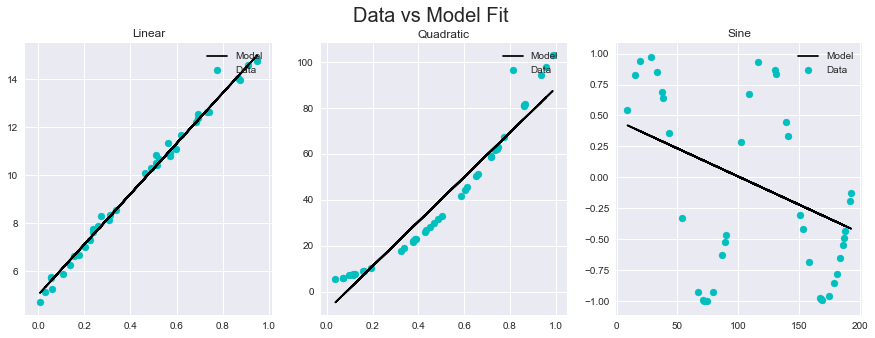

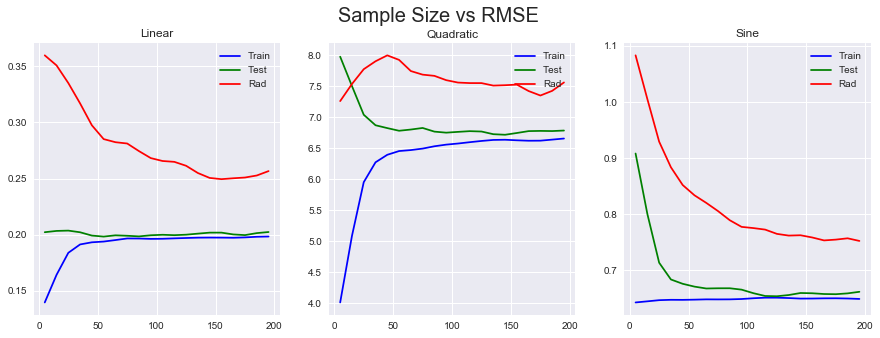

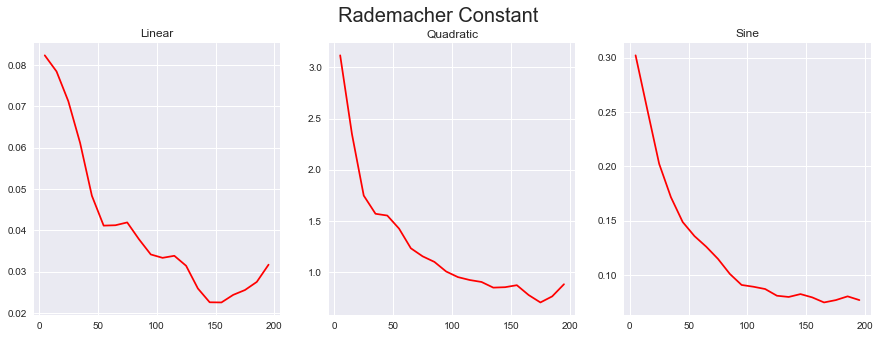

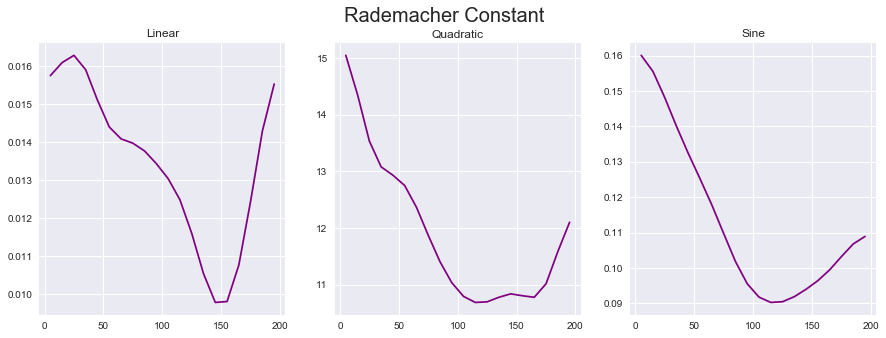

In [114]:
#Step 3: Evaluation
#Theory: Expect the model get better and better as sample size increase given bounds for VC dimension (test error decrease by a factor
#of aprox. sqrt(2m).
#Results: one can see that error indeed decreases with sample size, where irreducible error with little data for all 3 models.
#Error(linear) < error (quadratic) < error (sine)

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

funcs = ["Linear", "Quadratic", "Sine"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
fig.suptitle('Data vs Model Fit', fontsize=20)
for i in range(0,3):
    axes[i].set_title(funcs[i])
    axes[i].scatter(X_test[i],Y_test[i],color='c', label = 'Data')
    axes[i].plot(X_test[i], Y_pred_test[i], color = 'black', label = 'Model') 
    axes[i].legend(loc='upper right')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
fig.suptitle('Sample Size vs RMSE',fontsize=20)
for i in range(0,3):
    axes[i].set_title(funcs[i])
    #axes[i].set_xscale('log')
    #axes[i].set_yscale('log')
    axes[i].plot(n,gaussian_filter1d(train_error[i],sigma = 1),color='blue', label = 'Train')
    axes[i].plot(n,gaussian_filter1d(test_error[i],sigma = 1),color = 'green', label = 'Test')
    axes[i].plot(n,gaussian_filter1d(bound[i],sigma = 1), color = 'red', label = 'Rad')
    #axes[i].plot(n,gaussian_filter1d(boundVC[i],sigma = 1), color = 'purple', label = 'VC')
    axes[i].legend(loc='upper right')
plt.show()

#Rademacher
fig, axes = plt.subplots(1, 3, figsize = (15,5))
fig.suptitle('Rademacher Constant',fontsize=20)
for i in range(0,3):
    axes[i].set_title(funcs[i])
    axes[i].plot(n,gaussian_filter1d(Rad[i],sigma = 1),color='red')
plt.show()

#Rademacher
fig, axes = plt.subplots(1, 3, figsize = (15,5))
fig.suptitle('Rademacher Constant',fontsize=20)
for i in range(0,3):
    axes[i].set_title(funcs[i])
    axes[i].plot(n,gaussian_filter1d(VC[i],sigma = 2),color='purple')
plt.show()


In [120]:
#Experiment 2: varying  model capacity adding additive noise with std = 0.2, fixing 200 data points
#Theory: Expect model get worse as model capacity increases for a true linear model, as we increase model capactiy 
#by adding polynomials, we increase the VC dimension, which makes the error bound for the true model to be 
#more loose than it should be.

# Resuls: 
#Linear: as expected, as we increase model capacity we get worse RMSE given that the true function is linear.
# The more capacity the lower the bias; the less the bias the better the ability to fit data well, which increases variance.
#Quadratic: once polinomials of power 2 are added, increasing capacity have no much effect in the error.
#Sine: got consistent experimental results that is well aprox by polynomials degree 7.  


from sklearn.preprocessing import PolynomialFeatures


#step 1 - data generation        
x1 = np.random.uniform(0,1,200).reshape(-1,1)
e = np.random.normal(0,0.2,200).reshape(-1,1)
fs = 200 # sample rate for sin signal
x3 = np.arange(fs).reshape(-1,1)
y1 = (10.5*x1 +5 + e).reshape(-1,1) #linear
y2 = (10.5*x1 + 30*x1**2 +5 + e).reshape(-1,1) #quadratic
y3 = np.sin(2*np.pi*f * (x3/fs)).reshape(-1,1) #sin
pw = range(1,11,1)
#shuffling
idx = np.random.permutation(y3.shape[0])
x3= x3[idx]
y3 = y3[idx]
x1 = x1[idx]
y1= y1[idx]
y2 = y2[idx]


#y split
y1_train, y1_test = np.split(y1, [int(.8*len(y1))])
y2_train, y2_test = np.split(y2, [int(.8*len(y2))])
y3_train, y3_test = np.split(y3, [int(.8*len(y3))])

temp_test_errorp1 = []
temp_test_errorp2 = []
temp_test_errorp3 = []
temp_train_errorp1 = []
temp_train_errorp2 = []
temp_train_errorp3 = []
test_errorp1 = []
test_errorp2 = []
test_errorp3 = []
train_errorp1 = []
train_errorp2 = []
train_errorp3 = []
Radp1 = []
Radp2 = []
Radp3 = []
temp_Lp1 =[]
temp_Lp2 =[]
temp_Lp3 =[]


for i in pw:
    for j in range(0,100):
        #calculating polinomial features from 1 to 16 degree
        poly1 = PolynomialFeatures(degree = i) 
        poly2 = PolynomialFeatures(degree = i) 
        poly3 = PolynomialFeatures(degree = i) 
        x1_poly = poly1.fit_transform(x1)  
        x2_poly = poly2.fit_transform(x1)
        x3_poly = poly3.fit_transform(x3) 

        #x split
        x1_train, x1_test = np.split(x1_poly, [int(.8*len(x1))])
        x3_train, x3_test = np.split(x3_poly, [int(.8*len(x3))])

        #rademacher sigma
        s = np.random.binomial(1,0.5, len(x1_train))
        a = sum(s)
        while a.all() !=0:
            s = np.random.binomial(1,0.5, len(x1_train))
            s[s < 1] = -1
            a = sum(s)

        #Step 2: model training
        #fitting model
        poly1.fit(x1_train, y1_train)
        poly2.fit(x1_train, y2_train)
        poly3.fit(x3_train, y3_train)

        mp1 = LinearRegression()
        mp2 = LinearRegression()
        mp3 = LinearRegression()

        mp1.fit(x1_train,y1_train)
        mp2.fit(x1_train,y2_train)
        mp3.fit(x3_train,y3_train)

        #RMSE calculation
        y1p_test_pred = mp1.predict(x1_test)
        y2p_test_pred = mp2.predict(x1_test)
        y3p_test_pred = mp3.predict(x3_test)
        error1p_test = np.sqrt(mean_squared_error(y1_test, y1p_test_pred))
        error2p_test = np.sqrt(mean_squared_error(y2_test, y2p_test_pred))
        error3p_test = np.sqrt(mean_squared_error(y3_test, y3p_test_pred))

        y1p_train_pred = mp1.predict(x1_train)
        y2p_train_pred = mp2.predict(x1_train)
        y3p_train_pred = mp3.predict(x3_train)
        error1p_train = np.sqrt(mean_squared_error(y1_train, y1p_train_pred))
        error2p_train = np.sqrt(mean_squared_error(y2_train, y2p_train_pred))
        error3p_train = np.sqrt(mean_squared_error(y3_train, y3p_train_pred))

        temp_test_errorp1.append(error1p_test) 
        temp_test_errorp2.append(error2p_test) 
        temp_test_errorp3.append(error3p_test) 
        temp_train_errorp1.append(error1p_train) 
        temp_train_errorp2.append(error2p_train) 
        temp_train_errorp3.append(error3p_train)

        #Complexity
        L = np.dot(s, np.sqrt((y1_train-y1p_train_pred)**2))/len(y1_train)
        temp_Lp1.append(L)
        L = np.dot(s, np.sqrt((y2_train-y2p_train_pred)**2))/len(y2_train)
        temp_Lp2.append(L)
        L = np.dot(s, np.sqrt((y3_train-y3p_train_pred)**2))/len(y3_train)
        temp_Lp3.append(L)

    #     print("\nPolynommial: %d"% i)
    #     print("Test error Linear: %s" %error1p_test)
    #     print('Biases Linear: ', mp1.intercept_)
    #     print('Weights Linear: ', mp1.coef_)
    #     print("Test error Quadratic: %s" %error2p_test)
    #     print('Biases Quadratic: ', mp2.intercept_)
    #     print('Weights Quadratic: ', mp2.coef_)
    #     print("Test error Sine: %s" %error3p_test)
    #     print('Biases Sine: ', mp3.intercept_)
    #     print('Weights Sine: ', mp3.coef_)

    avgp1 = sum(temp_test_errorp1) / len(temp_test_errorp1) 
    avgp2 = sum(temp_test_errorp2) / len(temp_test_errorp2) 
    avgp3 = sum(temp_test_errorp3) / len(temp_test_errorp3) 
    avgp4 = sum(temp_train_errorp1)/ len(temp_train_errorp1)
    avgp5 = sum(temp_train_errorp2)/ len(temp_train_errorp2)
    avgp6 = sum(temp_train_errorp3)/ len(temp_train_errorp3)
    
    test_errorp1.append(avgp1)
    temp_test_errorp1.clear()
    test_errorp2.append(avgp2)
    temp_test_errorp2.clear() 
    test_errorp3.append(avgp3)
    temp_test_errorp3.clear()
    train_errorp1.append(avgp4)
    temp_train_errorp1.clear()
    train_errorp2.append(avgp5)
    temp_train_errorp2.clear()
    train_errorp3.append(avgp6)
    temp_train_errorp3.clear()
    
    Radp1.append(np.amax(temp_Lp1))
    temp_Lp1.clear()
    Radp2.append(np.amax(temp_Lp2))
    temp_Lp2.clear()
    Radp3.append(np.amax(temp_Lp3))
    temp_Lp3.clear()
    

#step 3: Evaluation
#Results and plots
# print("\nRMSE linear: ", test_errorp1)
# print("\nRMSE quadratic: ", test_errorp2)
# print("\nRMSE sine: ", test_errorp3)


In [121]:
boundp1 = []
boundp2 = []
boundp3 = []
delta = 0.1
a = np.ones(len(pw))*(0.3*(np.sqrt(np.log(2/delta)/200)))
boundp1 = np.add(train_errorp1, Radp1)
boundp1 = np.add(boundp1,a)
boundp2 = np.add(train_errorp2, Radp2)
boundp2 = np.add(boundp2,a)
boundp3 = np.add(train_errorp3, Radp3)
boundp3 = np.add(boundp3,a)

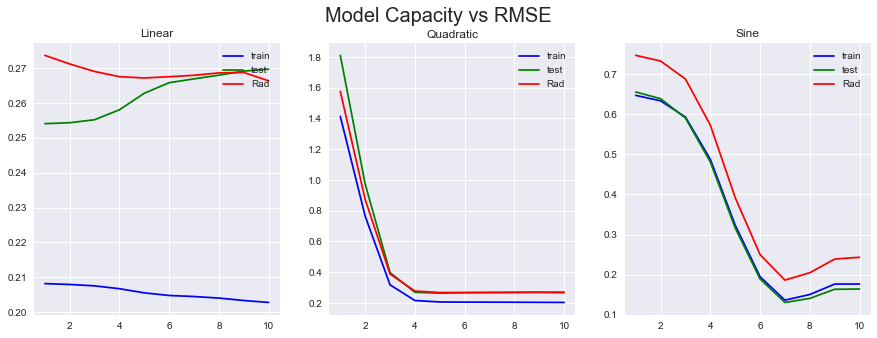

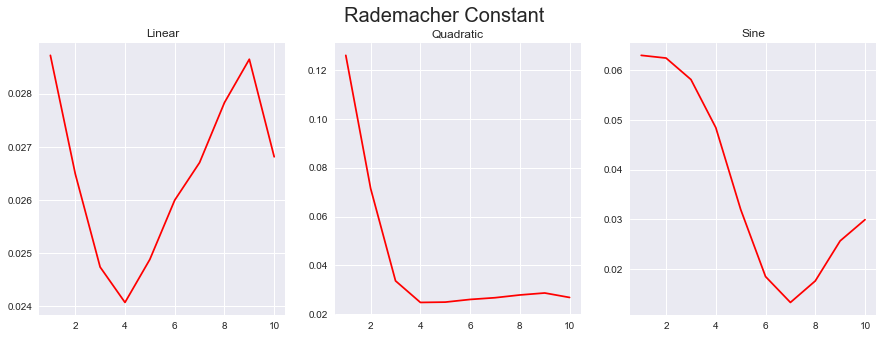

In [122]:
#step 3: Evaluation
#Results and plots
# print("\nRMSE linear: ", test_errorp1)
# print("\nRMSE quadratic: ", test_errorp2)
# print("\nRMSE sine: ", test_errorp3)

ysp1 = gaussian_filter1d(test_errorp1, sigma=1)
ysp2 = gaussian_filter1d(test_errorp2, sigma=1)
ysp3 = gaussian_filter1d(test_errorp3, sigma=1)
ytp1 = gaussian_filter1d(train_errorp1, sigma=1)
ytp2 = gaussian_filter1d(train_errorp2, sigma=1)
ytp3 = gaussian_filter1d(train_errorp3, sigma=1)
Radp1s = gaussian_filter1d(Radp1, sigma = 1)
Radp2s = gaussian_filter1d(Radp2, sigma = 1)
Radp3s = gaussian_filter1d(Radp3, sigma = 1)
boundp1s = gaussian_filter1d(boundp1, sigma = 1)
boundp2s = gaussian_filter1d(boundp2, sigma = 1)
boundp3s = gaussian_filter1d(boundp3, sigma = 1)

plt.style.use('seaborn')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15,5))
ax1.set_title("Linear")
ax2.set_title("Quadratic")
ax3.set_title("Sine")
fig.suptitle('Model Capacity vs RMSE',fontsize=20)
ax1.plot(pw,ytp1, color = 'blue', label = 'train')
ax1.plot(pw,ysp1,color='green', label = 'test')
ax1.plot(pw, boundp1s, color = 'red', label = 'Rad')
ax1.legend(loc = 'upper right')
ax2.plot(pw,ytp2, color = 'blue', label = 'train')
ax2.plot(pw,ysp2, color='green', label = 'test')
ax2.plot(pw, boundp2s, color = 'red', label = 'Rad')
ax2.legend(loc = 'upper right')
ax3.plot(pw,ytp3, color = 'blue', label = 'train')
ax3.plot(pw,ysp3,color='green', label = 'test')
ax3.plot(pw, boundp3s, color = 'red', label = 'Rad')
ax3.legend(loc = 'upper right')
plt.show()

#Rademacher
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize = (15,5))
fig.suptitle('Rademacher Constant',fontsize=20)
ax1.set_title("Linear")
ax2.set_title("Quadratic")
ax3.set_title("Sine")
ax1.plot(pw,Radp1s, color = 'red')
ax2.plot(pw,Radp2s, color = 'red')
ax3.plot(pw,Radp3s, color = 'red')
plt.show()



RMSE linear:  [0.1858903561714303, 0.18807688659395477, 0.18787436213312245, 0.1865150620689618, 0.18717491413719706, 0.18801625839673275, 0.19068318077860036, 0.18964009855602038, 0.1948527810913913]

RMSE quadratic:  [1.8263883427776504, 0.18807688659395919, 0.1878743621331249, 0.18651506206896332, 0.18717491413719858, 0.18801625839673114, 0.19068318077860952, 0.1896400985560171, 0.19485278109161336]

RMSE sine:  [0.6505926585881237, 0.6501896027146171, 0.7312296903581563, 0.8387712437065175, 0.4057591356913811, 0.5393404803499844, 0.11195974670739707, 0.05565968998410665, 0.18715515442447242]


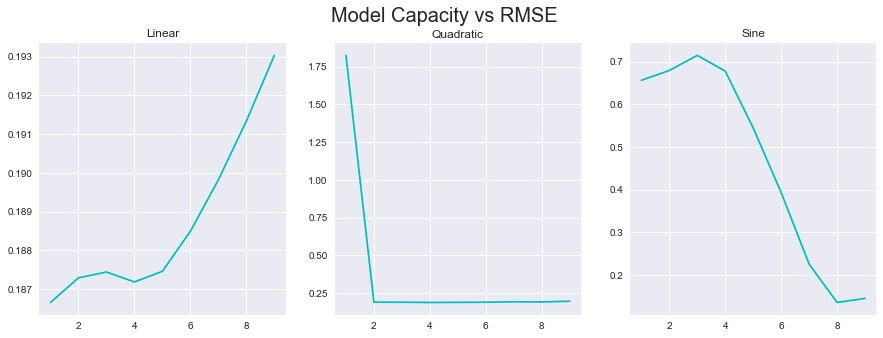

In [96]:
#step 3: Evaluation
#Results and plots
print("\nRMSE linear: ", test_errorp1)
print("\nRMSE quadratic: ", test_errorp2)
print("\nRMSE sine: ", test_errorp3)

plt.style.use('seaborn')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15,5))
fig.suptitle('Model Capacity vs RMSE',fontsize=20)
ax1.set_title("Linear")
ax2.set_title("Quadratic")
ax3.set_title("Sine")
ysp1 = gaussian_filter1d(test_errorp1, sigma=1)
ysp2 = gaussian_filter1d(test_errorp2, sigma=0.25)
ysp3 = gaussian_filter1d(test_errorp3, sigma=1)
ax1.plot(pw,ysp1,color='c')
ax2.plot(pw,ysp2,color='c')
ax3.plot(pw,ysp3,color='c')
plt.show()

In [ ]:
#Experiment 3: Varying model capacity[0,9] and sample size [5,100]. 
#Want to approx a cubic, what is the best polynomial? What is the best sample size?

n = range(5,200, 10)
pw = range(0,10,1)
test_error = np.zeros([len(pw),len(n)])
temp = []
temp2= []
for counter,value in enumerate(n): 
    for i in pw:
        for j in range(1,40):

            #step 1 - data generation        
            x = np.random.uniform(0,1,value).reshape(-1,1)
            e = np.random.normal(0,0.2,value).reshape(-1,1)
            #true function
            y = (10.5*x + 30*x**2 + 40*x**3 + e).reshape(-1,1) #cubic
            #shuffling data
            idx = np.random.permutation(y.shape[0])
            x= x[idx]
            y = y[idx]

            #creating polynomialfeatures
            poly = PolynomialFeatures(degree = i) 
            x_poly = poly.fit_transform(x) 

            #train split 
            x_train, x_test = np.split(x_poly, [int(.8*len(x))])
            y_train, y_test = np.split(y, [int(.8*len(y))])
            
            #step 2 - model training
            #initialisation of linear regression 
            m = LinearRegression()

            #inserting train data in model for training
            m.fit(x_train,y_train)

            #predicting values for test data
            y_pred = m.predict(x_test)

            #computing RMSE
            error = np.sqrt(mean_squared_error(y_test, y_pred))
            temp.append(error) 
#             print("\nSamples: %d" %value)
#             print("Power: %d" %i)
#             print("Counter: %d" %counter)
#             print("Error: %f" %error)
#             print("Temp: %s" %temp)

        avg = sum(temp) / len(temp) 
#         print("\n avg %f"%avg)
        temp2.append(avg)
#         print("temp2 %s"%temp2)
        temp.clear()
    test_error[:,counter] = temp2
    temp2.clear()
    print(test_error)
        

#     print("\nSample size: %d"% value
#     print("Test error: %s" %error)
#     print('Weight: ', m.coef_)
#     print('Bias: ', m.intercept_)
   


In [ ]:
#Step 3: evaluation
#Theory: would expect that polynomial with degree 3 would be the best aproximation for a cubic. The more data the better.
#Results: indeed polynomial with degree 3 got the min error but best result achieved with only 125, when the error curve 
#reaches a plateau.
#The lower degree polynomials (<3) achieve the highest error. Higher order polynomial achieve similar error bounds as for degree 3
#where even degrees require slightly more data.
print("Min RMSE: ", np.amin(test_error))
pos = np.where(test_error== np.amin(test_error))
print('Position of min RMSE: ', pos)
print(list(pw))
print(list(n))

plt.plot(n,test_error[3,:], color = 'c')
plt.show()

print('\nMin RMSE for each polynomial ')
print(np.amin(test_error, axis = 1))

#plotting
fig, axs = plt.subplots(2,5, figsize=(15, 6))
axs = axs.flatten()
for i in pw:
    y_s = gaussian_filter1d(test_error[i,:], sigma=3)
    axs[i].plot(n, y_s, color = 'c')
    axs[i].set_title("Polynomial %d" %i)
plt.show()


In [ ]:
#Experient 4: Comparing train and test error by training size for plain Linear regression

#Theory: training error increases and test error decreases as sample size increases. Both curves should converge.
#Low training error -> low bias
# small gap between training error curve and test error curve -> low variance
# linear regressor should be a good fit for a linear y

#Results: plot varies a lot, but the scale is also very small.

from sklearn.model_selection import learning_curve
import pandas as pd

x = np.random.uniform(0,1,100).reshape(-1,1)
e = np.random.normal(0,0.1,100).reshape(-1,1)
y = 10.5*x +4 + e.reshape(-1,1)
n = [15,25,35,45,55, 65,75]
train_sizes, train_scores, validation_scores = learning_curve(
estimator = LinearRegression(), X = x, y = y, train_sizes = n, cv = 5, scoring = 'neg_mean_squared_error')


print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) 
print('\nTest scores:\n\n', validation_scores)

train_scores_mean = -np.mean(train_scores, axis = 1)
validation_scores_mean = -np.mean(validation_scores, axis = 1)
print('\nTrain scores mean:\n\n', train_scores_mean)


plt.style.use('seaborn')
plt.plot(n, train_scores_mean, label = 'Training error')
plt.plot(n, validation_scores_mean, label = 'Test error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

In [ ]:
#Experient 5: Studying dimensionality of the input vs RMSE. True function is a hyperplane in 8D.

#Step 1: Data generation
w = np.array([1, 5, 3, 12, 6, 9, 33, 2])
dim = 8
tp1 = []
tp2 = []
error_multi1 = []
error_multi2 = []
n = range(5,100, 10)
for counter,value in enumerate(n): 
    for j in range(1,40):
        X = np.random.uniform(low= 0, high=1, size=(value,dim))
        e = np.random.normal(0,0.2,value)
        y1 = np.dot(X, w) + 3 + e #linear
        y2 = np.dot(X**3, w) + 3 + e #cubic

        #train split 
        X_train, X_test = np.split(X, [int(.8*len(X))])
        y1_train, y1_test = np.split(y1, [int(.8*len(y1))])
        y2_train, y2_test = np.split(y2, [int(.8*len(y2))])

        #Step 2: model fitting
        #initialisation of linear regression 
        lm1 = LinearRegression()
        lm2 = LinearRegression()

        #inserting train data in model for training
        lm1.fit(X_train,y1_train)
        lm2.fit(X_train,y2_train)

        #predicting values for test data
        y1_pred = lm1.predict(X_test)
        y2_pred = lm2.predict(X_test)

        #computing RMSE
        error_lm1 = np.sqrt(mean_squared_error(y1_test, y1_pred))
        tp1.append(error_lm1)
        error_lm2 = np.sqrt(mean_squared_error(y2_test, y2_pred))
        tp2.append(error_lm2)
        
        print("\nSample size: %d"%value)
        print("Test error1: %s" %error_lm1)
        print("Test error2: %s" %error_lm2)
        print('Weight1: ', lm1.coef_)
        print('Bias1: ', lm1.intercept_)
        print('Weight2: ', lm2.coef_)
        print('Bias2: ', lm2.intercept_)
        
    avg1 = sum(tp1)/len(tp1)
    error_multi1.append(avg1)
    tp1.clear()
    avg2 = sum(tp2)/len(tp2)
    error_multi2.append(avg2)
    tp2.clear()





In [ ]:
#step 3: Evaluation
#Theory: should expect that in higher dimensions, need more data and wrong model assumptions are more severely penalized.

#Results:
#Model assumptions match: Plain 8D regressor approx function with similar sample size as in 1D input. 
#Model assumptions do not match: true function is polynomial with degree 3/linear 8D regressor degrades more than in 1D input 
#for less data points but for more data points reach similar RMSE.(1D ~ 3, 8D ~ 3.5)
print("\nRMSE Linear Model: ", error_multi1)
print("\nRMSE Polynomial 3 Model: ", error_multi2)
print("\nEvaluating RMSE for the different curves")
print("Range for Linear Function [%.f, %.f]" %(min(y1_test), max(y1_test)) + " vs Range RMSE [%s, %s]" %(min(error_multi1), max(error_multi1)))
print("Range for Polynomial 3 Function [%.f, %.f]" %(min(y2_test), max(y2_test)) + " vs Range RMSE [%s, %s]" %(min(error_multi2), max(error_multi2)))

plt.style.use('seaborn')
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 6))
fig.suptitle('Sample size vs RMSE/8D',fontsize=20)
ax1.set_title("Linear")
ax1.plot(n,error_multi1,color='c')
ax2.set_title("Polynomial degree 3")
ax2.plot(n,error_multi2,color='c')
plt.show()


In [ ]:
#Experiment comparison 5: 1D

n = range(5,100, 10)
test_error1 =[]
test_error2 = []
temp1 = []
temp2=[]

for counter,value in enumerate(n): 
    for j in range(1,40):
        
        #step 1 - data generation        
        x1 = np.random.uniform(0,1,value).reshape(-1,1)
        e = np.random.normal(0,0.2,value).reshape(-1,1)
        y1 = (10.5*x1 +5 + e).reshape(-1,1) #linear
        y2 = (10*x1 + 10*x1**2 + 20*x1**3+ 5 + e).reshape(-1,1) #cubic

        
        #train split 
        x1_train, x1_test = np.split(x1, [int(.8*len(x1))])
        y1_train, y1_test = np.split(y1, [int(.8*len(y1))])
        y2_train, y2_test = np.split(y2, [int(.8*len(y2))])
        
        #Step 2: model fitting
        #initialisation of linear regression 
        m1 = LinearRegression()
        m2 = LinearRegression()
        
        #inserting train data in model for training
        m1.fit(x1_train,y1_train)
        m2.fit(x1_train,y2_train)

        #predicting values for test data
        y1_pred = m1.predict(x1_test)
        y2_pred = m2.predict(x1_test)

        #computing RMSE
        error1 = np.sqrt(mean_squared_error(y1_test, y1_pred))
        error2 = np.sqrt(mean_squared_error(y2_test, y2_pred))
        temp1.append(error1) 
        temp2.append(error2) 

    avg1 = sum(temp1) / len(temp1) 
    avg2 = sum(temp2) / len(temp2) 

    
    test_error1.append(avg1)
    temp1.clear()
    
    test_error2.append(avg2)
    temp2.clear()
    
print("\nRMSE Linear Model: ", test_error1)
print("\nRMSE Polynomial 3 Model: ", test_error2)
print("\nEvaluating RMSE for the different curves")
print("Range for Linear Function [%.f, %.f]" %(min(y1_test), max(y1_test)) + " vs Range RMSE [%s, %s]" %(min(test_error1), max(test_error1)))
print("Range for Polynomial 3 Function [%.f, %.f]" %(min(y2_test), max(y2_test)) + " vs Range RMSE [%s, %s]" %(min(test_error2), max(test_error2)))

    
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle('Sample Size vs RMSE/1D',fontsize=20)
ax1.plot(n,test_error1,color='c')
ax1.set_title("Linear")
ax2.plot(n,test_error2,color='c')
ax2.set_title("Polynomial degree 3")
plt.show()

    

In [ ]:
import sympy
from sympy.solvers.inequalities import reduce_inequalities
from sympy import Symbol

h = Symbol('h', real=True)
n = 20
a = 0.32
b = 0.64
reduce_inequalities(h*(1-sympy.log(h/n)) >= n*((-a/b + 1)**2) - (sympy.log(n))/2, [h])

